In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 提取主力合约

In [3]:
trainset_path = '/home/chocolate/Train_data/'
trainset_main_path = '/home/chocolate/Train_data_main/'
file_list = os.listdir(trainset_path)
for i in range(len(file_list)):
    train_data = pd.read_csv(trainset_path + file_list[i],encoding="gbk")
    train_data = train_data.sort_values(by='Time')  # 对原数据重新按时间排序，因为有些数据顺序被打乱了。
#     train_data = train_data[:-5] # 最后5分钟的数据不可取，去除
    newtime = pd.to_datetime(train_data['Time']) # 将时间转换为datetime格式
    newtime_list = list(train_data['Time']) # 将时间Series格式转换为list
    main_month = newtime.iloc[-1].month # 提取主力合约的月份
    if i == 0:
        for j in range(len(train_data)):
            if newtime.iloc[j].month != main_month:
                 train_data.drop(j,inplace=True) # 如果不是主力合约的数据直接删除
        train_data.to_csv(trainset_main_path + file_list[i].split('.')[0]+ '_main' + '.csv',sep=',') # 将提取的主力合约另存为csv文件
        main_last_time = train_data['Time'].iloc[-10] # 取上一个合约最后一个交割日的时间
        print "第一个合约交割日时间：",main_last_time
    else:
        main_last_index = newtime_list.index(main_last_time) # 返回上一个合约的交割日在当前合约中的索引
        print "上个合约交割时间所在当前合约的索引：",main_last_index
        for k in range(len(train_data)):
            if k< main_last_index:
                train_data.drop(k,inplace=True) # 如果不是主力合约的数据直接删除
        print "当前主力合约起始时间：",train_data['Time'].iloc[1]
        train_data.to_csv(trainset_main_path + file_list[i].split('.')[0]+ '_main' + '.csv',sep=',') # 将提取的主力合约另存为csv文件
        main_last_time = train_data['Time'].iloc[-10] # 取上一个合约最后一个交割日的时间
        print "当前合约交割日时间：",main_last_time

KeyboardInterrupt: 

# 进行数据筛选和清理，生成清理后的主力合约文件，并提取出训练集

In [18]:
# 读取已经提取好的主力合约文件
path = '/home/chocolate/LSTM-source/'
data = pd.read_csv(path + 'MINU_IF_zhuli_201406-_201609.csv') 
data['Time'] = pd.to_datetime(data['Time']) 
data.index = range(len(data))
delete_list = []
# 选择2016年1-8月的主力合约数据作为训练集，在主力合约中进行提取
# 删除非正常交易时间的数据，交易时间为上午9：30-11：30，下午1:00到3:00
# 因为每天开盘的前10分钟和收盘的最后10分钟数据波动较大，暂时在训练时去掉这些数据
for k in range(len(data)):
    if data['Time'].iloc[k].year != 2016:
        delete_list.append(k)
    elif data['Time'].iloc[k].month >=9:
        delete_list.append(k)
    elif data['Time'].iloc[k].hour < 9:
        delete_list.append(k)
    elif data['Time'].iloc[k].hour == 9 and data['Time'].iloc[k].minute <= 39:
        delete_list.append(k)
    elif data['Time'].iloc[k].hour == 14 and data['Time'].iloc[k].minute >= 50:
         delete_list.append(k)
    elif data['Time'].iloc[k].hour >= 15:
        delete_list.append(k)
        
for j in range(len(data)):
    if j in delete_list:
        data.drop(j,inplace=True)
data= data.sort_values(by = 'Time')

# 一分钟之内，最大股价和最低股价相差超过50点的，那么应该尽量删掉这些数据。
# 删除一分钟成交量大于1000的，这些数据可能会影响整体数据
for k in range(len(data)):
    if data['MaxPrice'].iloc[k] - data['MinPrice'].iloc[k] > 50:
       delete_list.append(k)
    elif data['Volume'].iloc[k] > 1000:
       delete_list.append(k)
data.to_csv(path + 'cleaned_train_data.csv')

In [59]:
data.describe

<bound method DataFrame.describe of        Unnamed: 0                      Date                 Time  Latestprice  \
0          106856  2016-01-04T01:40:00.000Z  2016-01-04 09:40:00       3640.4   
1          106857  2016-01-04T01:41:00.000Z  2016-01-04 09:41:00       3625.8   
2          106858  2016-01-04T01:42:00.000Z  2016-01-04 09:42:00       3618.8   
3          106859  2016-01-04T01:43:00.000Z  2016-01-04 09:43:00       3617.0   
4          106860  2016-01-04T01:44:00.000Z  2016-01-04 09:44:00       3618.0   
5          106862  2016-01-04T01:44:00.000Z  2016-01-04 09:44:00       3621.0   
6          106861  2016-01-04T01:46:00.000Z  2016-01-04 09:46:00       3614.2   
7          106863  2016-01-04T01:46:00.000Z  2016-01-04 09:46:00       3601.2   
8          106864  2016-01-04T01:47:00.000Z  2016-01-04 09:47:00       3602.2   
9          106865  2016-01-04T01:49:00.000Z  2016-01-04 09:49:00       3604.6   
10         106867  2016-01-04T01:50:00.000Z  2016-01-04 09:50:00       36

# 加入MA、EMA、MACD指标

## 加入5分钟、12分钟、26分钟的MA、EMA指标

In [3]:
import seaborn as sns
import datetime
path = '/home/chocolate/LSTM-source/'
data = pd.read_csv(path + 'cleaned_train_data.csv')
data
newTime = pd.to_datetime(data['Time']) # 将时间转换成datetime格式
ma_list = [5, 12, 26]
newdata1 = []
#  添加收盘价的移动平均线MA和指数平滑移动平均线EMA
newdata1 = pd.concat([newTime,data[['Latestprice','MaxPrice','MinPrice','Stockup','Turnover','Position','Volume','First.Latestprice','Last.Buy1price','Last.Buy1quantity','Last.Sell1price','Last.Sell1quantity']]], axis = 1)
for ma in ma_list:
    newdata1['MA_' + str(ma)] = pd.rolling_mean(data['Latestprice'], ma)
    # 计算移动平均线之间的距离
newdata1['Dis_MA5_26'] = newdata1['MA_5'] - newdata1['MA_26']
    # 计算指数平滑移动平均线
for ma in ma_list:
    newdata1['EMA_' + str(ma)] = pd.ewma(newdata1['Latestprice'], span=ma)
    # 计算指数平滑移动平均线之间的距离
newdata1['Dis_EMA5_26'] = newdata1['EMA_5'] - newdata1['EMA_26']
    
# 添加成交量的移动平均线MA和指数平滑移动平均线EMA
for ma in ma_list:
    newdata1['Vol_MA_'+str(ma)] =  pd.rolling_mean(data['Volume'], ma)
# 计算成交量移动平均线之间的距离
newdata1['Dis_Vol_MA5_26'] = newdata1['Vol_MA_5'] - newdata1['Vol_MA_26']
# 添加成交量的指数平滑移动平均线
for ma in ma_list:
    newdata1['Vol_EMA_'+str(ma)] = pd.ewma(newdata1['Volume'], span=ma)
# 计算指数平滑移动平均线之间的距离
newdata1['Dis_Vol_EMA5_26'] = newdata1['Vol_EMA_5'] - newdata1['Vol_EMA_26']  



IOError: File /home/chocolate/LSTM-source/cleaned_train_data.csv does not exist

In [18]:
newdata1

,Time,Latestprice,MaxPrice,MinPrice,Stockup,Turnover,Position,Volume,First.Latestprice,Last.Buy1price,...,EMA_26,Dis_EMA5_26,Vol_MA_5,Vol_MA_12,Vol_MA_26,Dis_Vol_MA5_26,Vol_EMA_5,Vol_EMA_12,Vol_EMA_26,Dis_Vol_EMA5_26
0,2016-01-04 09:40:00,3640.4,3646.0,3640.2,-63,115844340,28315,106,3644.8,3640.2,...,3640.400000,0.000000,NaN,NaN,NaN,NaN,106.000000,106.000000,106.000000,0.000000
1,2016-01-04 09:41:00,3625.8,3641.4,3624.4,-79,228902820,28236,210,3640.4,3625.0,...,3632.819231,-1.179231,NaN,NaN,NaN,NaN,168.400000,162.333333,160.000000,8.400000
2,2016-01-04 09:42:00,3618.8,3626.8,3612.6,-110,301745580,28126,278,3625.4,3619.2,...,3627.782257,-2.224363,NaN,NaN,NaN,NaN,220.315789,207.478060,202.396254,17.919535
3,2016-01-04 09:43:00,3617.0,3620.2,3616.0,-81,162817740,28045,150,3618.8,3616.8,...,3624.768009,-2.764932,NaN,NaN,NaN,NaN,191.107692,189.334483,187.748551,3.359141
4,2016-01-04 09:44:00,3618.0,3618.8,3613.0,-66,143205060,27979,132,3616.8,3618.0,...,3623.198480,-2.732129,175.2,NaN,NaN,NaN,168.417062,173.756909,174.820232,-6.403171
5,2016-01-04 09:44:00,3621.0,3621.6,3618.0,-47,111857580,27931,103,3618.2,3621.0,...,3622.758142,-2.096789,174.6,NaN,NaN,NaN,144.512782,156.559257,160.435213,-15.922431
6,2016-01-04 09:46:00,3614.2,3621.4,3614.2,-46,120504420,27885,111,3621.0,3612.8,...,3621.236121,-2.862444,154.8,NaN,NaN,NaN,132.647402,146.392868,151.643416,-18.996015
7,2016-01-04 09:46:00,3601.2,3615.6,3600.0,-98,372121500,27787,344,3614.2,3601.0,...,3618.007805,-5.591120,168.0,NaN,NaN,NaN,205.958763,187.630431,182.636828,23.321935
8,2016-01-04 09:47:00,3602.2,3608.6,3600.4,-68,195712320,27719,181,3601.2,3602.2,...,3615.664742,-6.744570,174.2,NaN,NaN,NaN,197.416984,186.318696,182.394214,15.022770
9,2016-01-04 09:49:00,3604.6,3608.4,3599.0,-70,198897300,27649,184,3602.0,3603.4,...,3614.137915,-6.683214,184.6,NaN,NaN,NaN,192.865730,185.879304,182.615797,10.249933


移动平均线


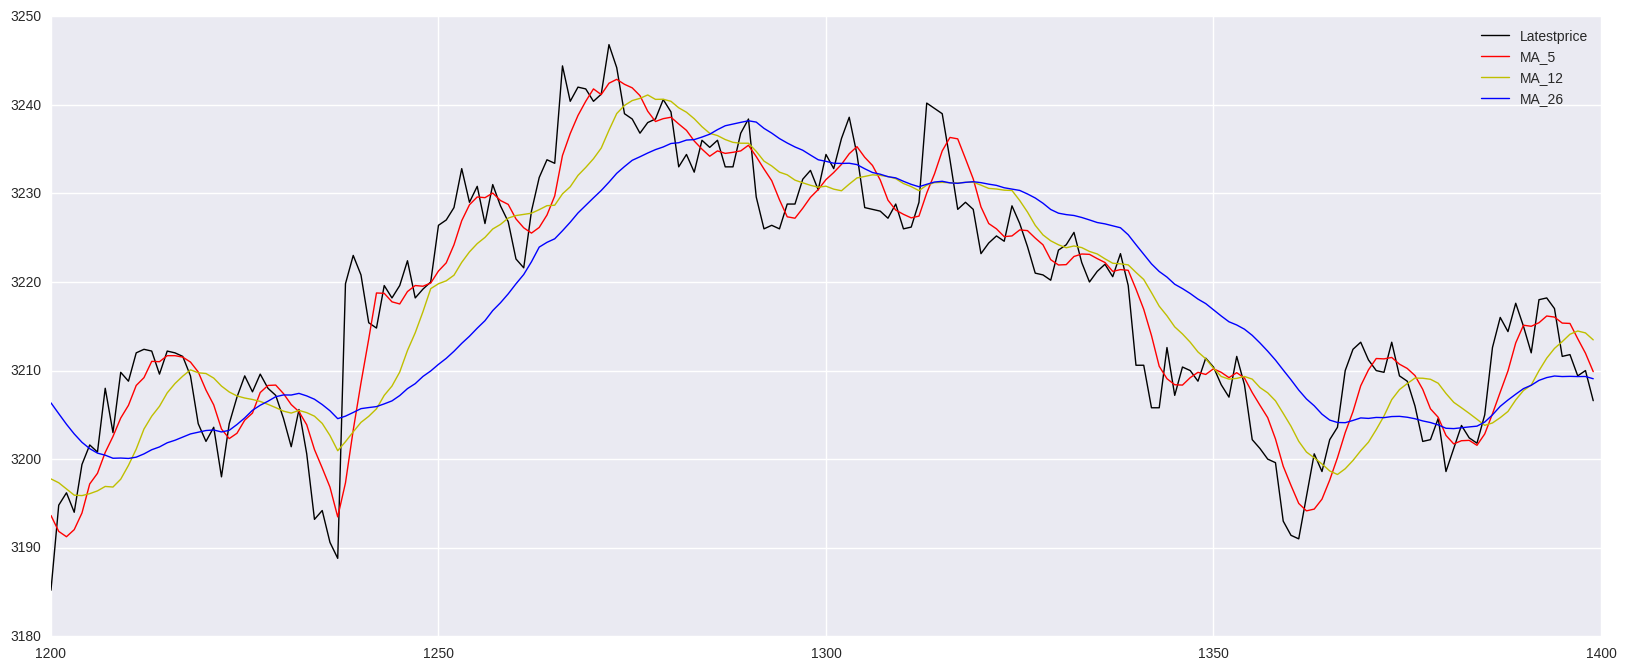

指数平滑移动平均线


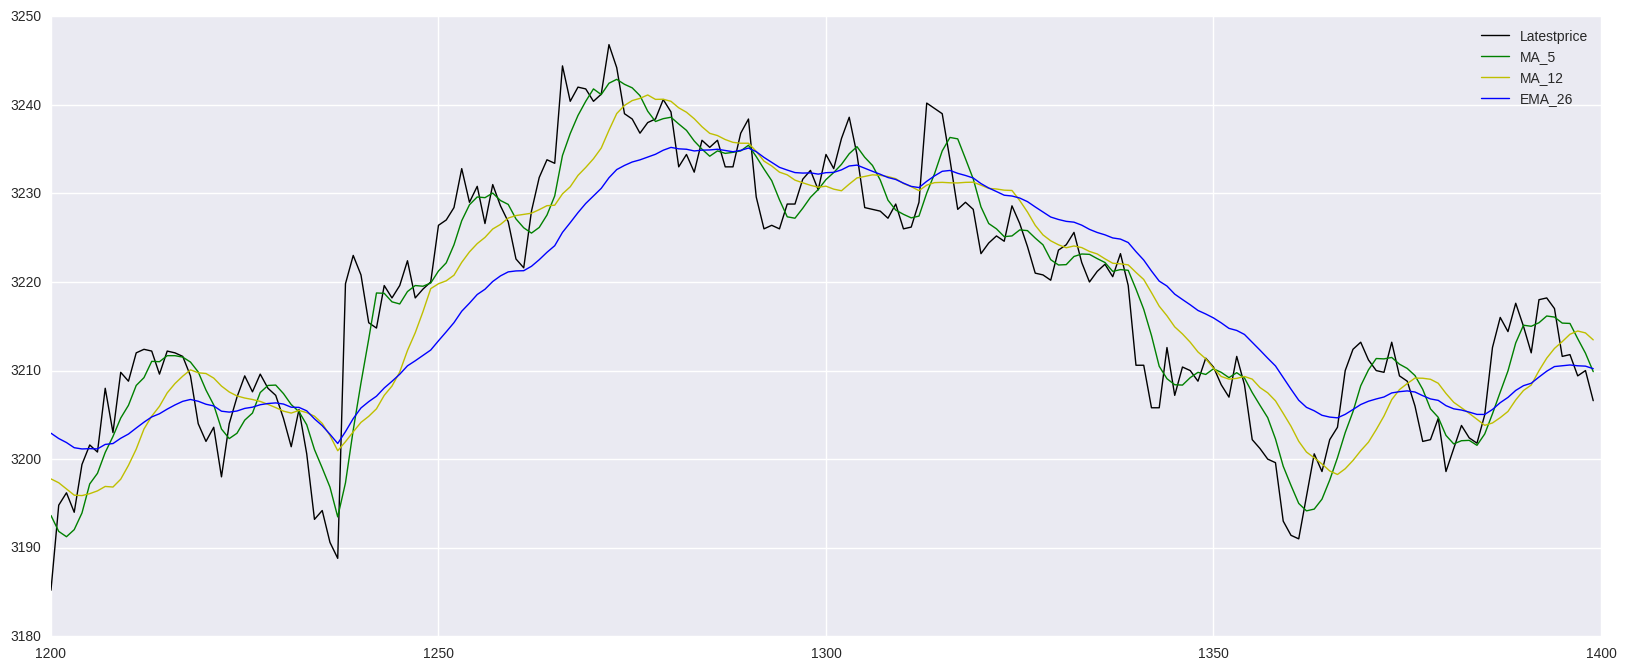

In [19]:
#作出某一段的MA和EMA图
plt.figure(figsize=(20,8))
print u"移动平均线"
plt.plot(newdata1['Latestprice'][1200:1400],"black", label="Latestprice",linewidth=1)
plt.plot(newdata1['MA_5'][1200:1400], "r-", label="MA_5",linewidth=1)
plt.plot(newdata1['MA_12'][1200:1400], "y", label="MA_12",linewidth=1)
plt.plot(newdata1['MA_26'][1200:1400], "blue", label="MA_26",linewidth=1)
plt.legend()
plt.show()
print u"指数平滑移动平均线"
plt.figure(figsize=(20,8))
plt.plot(newdata1['Latestprice'][1200:1400], "black", label="Latestprice",linewidth=1)
plt.plot(newdata1['MA_5'][1200:1400], "g-", label="MA_5",linewidth=1)
plt.plot(newdata1['MA_12'][1200:1400], "y-", label="MA_12",linewidth=1)
plt.plot(newdata1['EMA_26'][1200:1400], "b-", label="EMA_26",linewidth=1)
plt.legend()
plt.show() 

均线分析

移动平均线对价格波动较为明显，抗干扰能力比较差。
指数平滑移动平均线对价格波动不是较为明显，反应的是一个大体趋势，对微小震荡有比较好的容忍能力。


# 添加平滑异同平均线MACD指标

指数平滑移动平均线


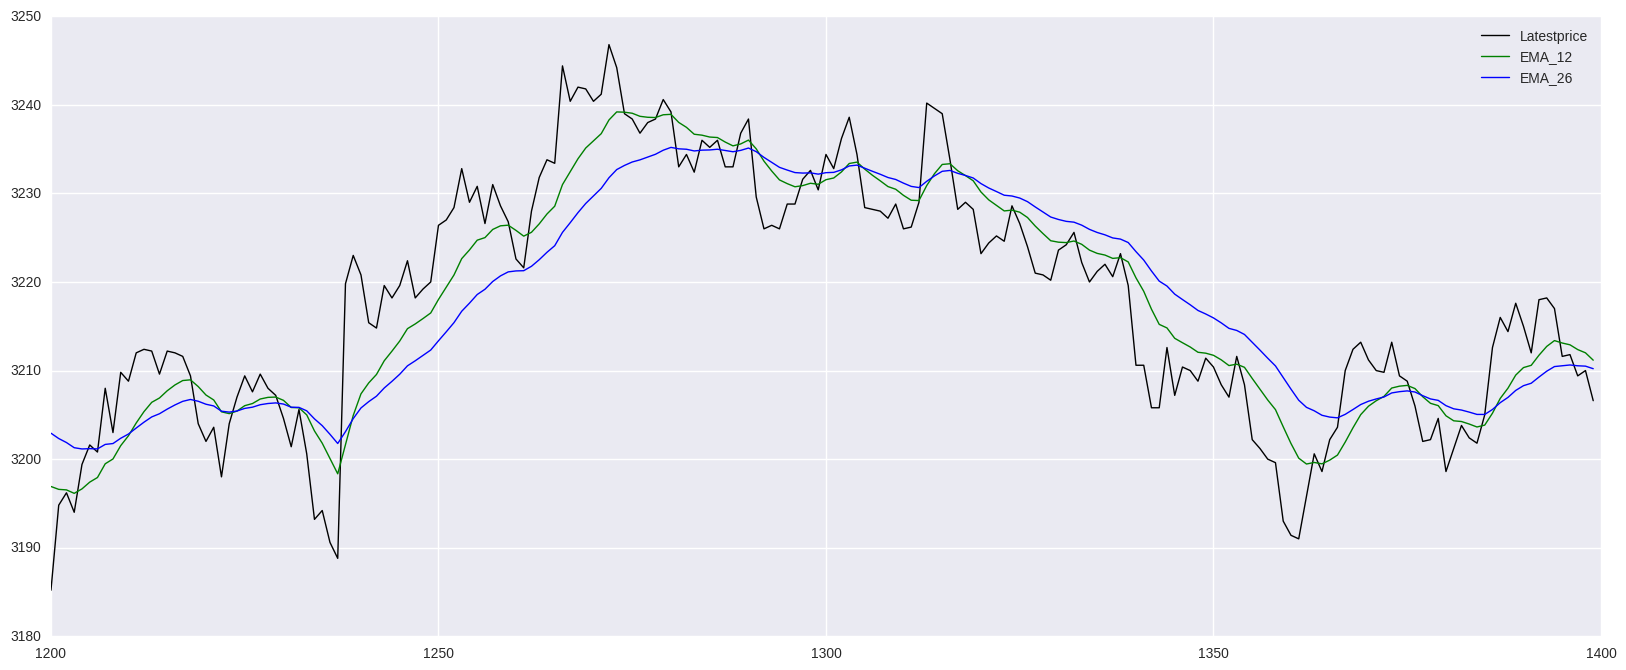

DIFF与DEA离差值，柱状图


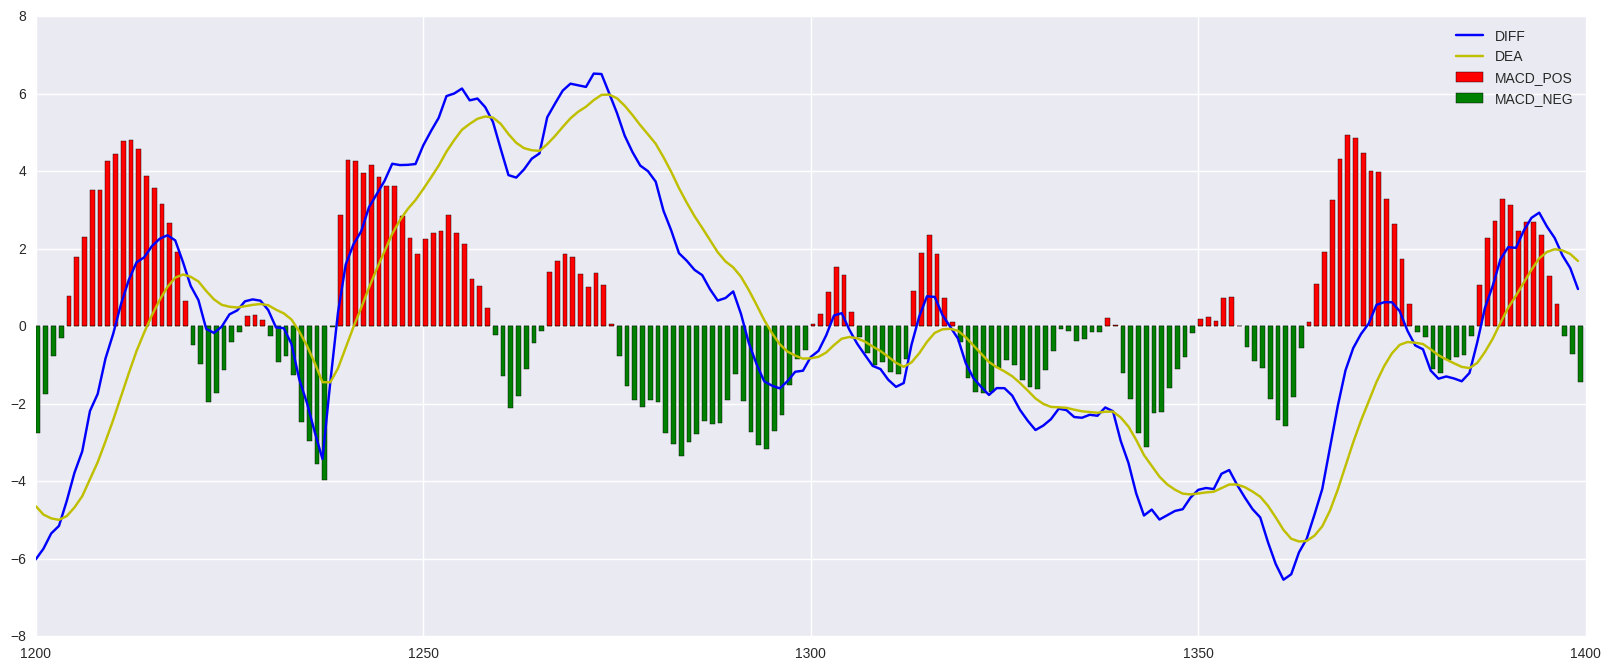

In [31]:
# EMA_12是快速指数移动平均线，EMA_26是慢速指数移动平均线      
# 计算DIFF
newdata1['DIFF_12_26'] = newdata1['EMA_12'] - newdata1['EMA_26']
# 计算离差平均值DEA，也就是计算离差值的指数平滑移动平均，设置为5分钟的指数平滑曲线
newdata1['DEA_12_26'] =  pd.ewma(newdata1['DIFF_12_26'],span = 9)
# 计算MACD值
newdata1['MACD'] = 2*(newdata1['DIFF_12_26'] - newdata1['DEA_12_26'])
# 对MACD柱状图进行处理，便于画图
macd_pos = [] 
macd_neg = []
for j in range(len(newdata1['MACD'])):
    if newdata1['MACD'].iloc[j] >= 0:
        macd_pos.append(newdata1['MACD'].iloc[j])
        macd_neg.append(0)
    else:
        macd_neg.append(newdata1['MACD'].iloc[j])
        macd_pos.append(0)
print u"指数平滑移动平均线"
plt.figure(figsize=(20,8))
plt.plot(newdata1['Latestprice'][1200:1400], "black", label="Latestprice",linewidth=1)
plt.plot(newdata1['EMA_12'][1200:1400], "g-", label="EMA_12",linewidth=1)
plt.plot(newdata1['EMA_26'][1200:1400], "b-", label="EMA_26",linewidth=1)        
plt.legend()
plt.show()
print u"DIFF与DEA离差值，柱状图"
plt.figure(figsize=(20,8))
plt.plot(newdata1['DIFF_12_26'][1200:1400],'b',label='DIFF')
plt.plot(newdata1['DEA_12_26'][1200:1400],"y",label='DEA')
plt.bar(range(1200,1400),macd_pos[1200:1400],0.6,color="red", label="MACD_POS")
plt.bar(range(1200,1400),macd_neg[1200:1400],0.6,color="green", label="MACD_NEG")
plt.legend()
plt.show()
train_data_addMA = newdata1
train_data_addMA.to_csv(path + 'train_data_addMA.csv') # 存储为加MA特征的数据

In [30]:
train_data_addMA

,Time,Latestprice,MaxPrice,MinPrice,Stockup,Turnover,Position,Volume,First.Latestprice,Last.Buy1price,...,Vol_MA_12,Vol_MA_26,Dis_Vol_MA5_26,Vol_EMA_5,Vol_EMA_12,Vol_EMA_26,Dis_Vol_EMA5_26,DIFF_12_26,DEA_12_26,MACD
0,2016-01-04 09:40:00,3640.4,3646.0,3640.2,-63,115844340,28315,106,3644.8,3640.2,...,NaN,NaN,NaN,106.000000,106.000000,106.000000,0.000000,0.000000,0.000000,0.000000
1,2016-01-04 09:41:00,3625.8,3641.4,3624.4,-79,228902820,28236,210,3640.4,3625.0,...,NaN,NaN,NaN,168.400000,162.333333,160.000000,8.400000,-0.327564,-0.181980,-0.291168
2,2016-01-04 09:42:00,3618.8,3626.8,3612.6,-110,301745580,28126,278,3625.4,3619.2,...,NaN,NaN,NaN,220.315789,207.478060,202.396254,17.919535,-0.634451,-0.367419,-0.534064
3,2016-01-04 09:43:00,3617.0,3620.2,3616.0,-81,162817740,28045,150,3618.8,3616.8,...,NaN,NaN,NaN,191.107692,189.334483,187.748551,3.359141,-0.823469,-0.521908,-0.603123
4,2016-01-04 09:44:00,3618.0,3618.8,3613.0,-66,143205060,27979,132,3616.8,3618.0,...,NaN,NaN,NaN,168.417062,173.756909,174.820232,-6.403171,-0.869050,-0.625175,-0.487751
5,2016-01-04 09:44:00,3621.0,3621.6,3618.0,-47,111857580,27931,103,3618.2,3621.0,...,NaN,NaN,NaN,144.512782,156.559257,160.435213,-15.922431,-0.751834,-0.659506,-0.184655
6,2016-01-04 09:46:00,3614.2,3621.4,3614.2,-46,120504420,27885,111,3621.0,3612.8,...,NaN,NaN,NaN,132.647402,146.392868,151.643416,-18.996015,-0.971763,-0.738530,-0.466465
7,2016-01-04 09:46:00,3601.2,3615.6,3600.0,-98,372121500,27787,344,3614.2,3601.0,...,NaN,NaN,NaN,205.958763,187.630431,182.636828,23.321935,-1.721885,-0.974849,-1.494072
8,2016-01-04 09:47:00,3602.2,3608.6,3600.4,-68,195712320,27719,181,3601.2,3602.2,...,NaN,NaN,NaN,197.416984,186.318696,182.394214,15.022770,-2.165518,-1.249899,-1.831237
9,2016-01-04 09:49:00,3604.6,3608.4,3599.0,-70,198897300,27649,184,3602.0,3603.4,...,NaN,NaN,NaN,192.865730,185.879304,182.615797,10.249933,-2.325090,-1.490804,-1.668572


# 添加RSI指标

# 添加布林带指标

# 提取出清理后的测试集

In [1]:
# 读取已经提取好的主力合约文件
path = '/home/chocolate/LSTM-source/'
data = pd.read_csv(path + 'MINU_IF_zhuli_201406-_201609.csv') 
data['Time'] = pd.to_datetime(data['Time']) 
data.index = range(len(data))
delete_list = []
# 选择2016年9月的主力合约数据作为测试集，在主力合约中进行提取
# 删除非正常交易时间的数据，交易时间为上午9：30-11：30，下午1:00到3:00
# 因为每天开盘的前10分钟和收盘的最后10分钟数据波动较大，暂时在测试时去掉这些数据
# 一分钟之内，最大股价和最低股价相差超过50点的，那么应该尽量删掉这些数据。
# 删除一分钟成交量大于1000的，这些数据可能会影响整体数据
for k in range(len(data)):
    if data['Time'].iloc[k].year < 2016:
        delete_list.append(k)
    elif data['Time'].iloc[k].month < 9:
        delete_list.append(k)
    elif data['Time'].iloc[k].hour == 9 and data['Time'].iloc[k].minute <= 39:
        delete_list.append(k)
    elif data['Time'].iloc[k].hour == 14 and data['Time'].iloc[k].minute >= 50:
         delete_list.append(k)
    elif data['Time'].iloc[k].hour >= 15:
        delete_list.append(k)
    elif data['MaxPrice'].iloc[k] - data['MinPrice'].iloc[k] > 50:
         delete_list.append(k)
    elif data['Volume'].iloc[k] > 1000:
         delete_list.append(k)
        
for j in range(len(data)):
    if j in delete_list:
        data.drop(j,inplace=True)
test_data= data.sort_values(by = 'Time')

test_data.to_csv(path + 'test_data.csv')

NameError: name 'pd' is not defined

# 利用LSTM对训练集进行训练

## 每次执行可从此处开始

In [66]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import pandas as pd
from pandas import Series,DataFrame
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
import cPickle
import gzip
%matplotlib inline

# 提取训练数据和测试数据
path = '/home/chocolate/LSTM-source/'
train_data = pd.read_csv(path + 'train_data_addMA.csv')
test_data = pd.read_csv(path + 'test_data.csv')

In [67]:
# 打标签
# 根据当前分钟收盘价相对于开盘价的涨跌幅，将训练集和测试集分成五类——大涨、小涨、平稳、大跌、小跌
train_data['RaiseDown'] = (train_data['Latestprice'] - train_data['First.Latestprice'])/train_data['First.Latestprice']
test_data['RaiseDown'] = (test_data['Latestprice'] - test_data['First.Latestprice'])//test_data['First.Latestprice']
train_data = train_data.fillna(0)

test_label.shape


(4399,)

In [68]:
train_data1 = train_data.ix[1:100,3:]
train_data1.shape
test_data = train_data.ix[101:110,3:]
test_data.shape

(10, 31)

In [69]:
test_data
train_label = []
for i in train_data1['RaiseDown']:
    if i > 0.002:
        train_label.append(1)
    elif i > 0.0005:
        train_label.append(2)
    elif i> -0.0005:
        train_label.append(3)
    elif i > -0.002:
        train_label.append(4)
    else:
        train_label.append(5)
train_label = np.array(train_label)
# train_data.shape
# train_label.shape
# train_data['RaiseDown']
test_label = []
for i in test_data['RaiseDown']:
    if i > 0.002:
        test_label.append(1)
    elif i > 0.0005:
        test_label.append(2)
    elif i> -0.0005:
        test_label.append(3)
    elif i > -0.002:
        test_label.append(4)
    else:
        test_label.append(5)
test_label = np.array(test_label)
tf.reset_default_graph()

## 用回归模型进行测试

In [70]:
TIME_STEP = 31
TRAINING_STEPS = 8000
BATCH_SIZE = 2000
# 利用tensorflow构建rnn回归预测模型
def input_fn(X):
    # 将时间窗口序列分割为时间点数据
    return tf.split(1, TIME_STEP, X)

train_data1 = np.array(train_data1)
# def exp_decay(global_step):
#     # 将本函数作为参数带入learn_rate可让回归器训练过程中动态调整训练步长
#     return tf.train.exponential_decay(learning_rate=0.003,
#                                       global_step=global_step,
#                                       decay_steps=1000,
#                                       decay_rate=0.3)

# 设置rnn回归模型参数
regressor = learn.TensorFlowRNNRegressor(rnn_size=TIME_STEP,
                                         cell_type='lstm',
                                         steps=TRAINING_STEPS,
                                         num_layers=1,
                                         learning_rate=0.003,
                                         batch_size=BATCH_SIZE,
                                         verbose=2, input_op_fn=input_fn)
# 开始训练
regressor.fit(train_data1, train_label)



Step #100, epoch #100, avg. train loss: 2.35973
Step #200, epoch #200, avg. train loss: 0.53918
Step #300, epoch #300, avg. train loss: 0.53255
Step #400, epoch #400, avg. train loss: 0.52749
Step #500, epoch #500, avg. train loss: 0.52316
Step #600, epoch #600, avg. train loss: 0.51888
Step #700, epoch #700, avg. train loss: 0.51489
Step #800, epoch #800, avg. train loss: 0.51084
Step #900, epoch #900, avg. train loss: 0.50692
Step #1000, epoch #1000, avg. train loss: 0.50319
Step #1100, epoch #1100, avg. train loss: 0.49943
Step #1200, epoch #1200, avg. train loss: 0.49558
Step #1300, epoch #1300, avg. train loss: 0.49164
Step #1400, epoch #1400, avg. train loss: 0.48760
Step #1500, epoch #1500, avg. train loss: 0.48346
Step #1600, epoch #1600, avg. train loss: 0.47923
Step #1700, epoch #1700, avg. train loss: 0.47492
Step #1800, epoch #1800, avg. train loss: 0.47054
Step #1900, epoch #1900, avg. train loss: 0.46611
Step #2000, epoch #2000, avg. train loss: 0.46166
Step #2100, epoch 

TensorFlowRNNRegressor(batch_size=2000, bidirectional=False, cell_type='lstm',
            clip_gradients=5.0, config=None, continue_training=False,
            initial_state=None,
            input_op_fn=<function input_fn at 0x7f1a94d2ba28>,
            learning_rate=0.003, n_classes=0, num_layers=1,
            optimizer='Adagrad', rnn_size=31, sequence_length=None,
            steps=8000, verbose=2)

In [72]:
predicted = regressor.predict(test_data)

test_label

array([1, 3, 2, 2, 4, 4, 2, 5, 3, 3])

In [73]:
predicted

array([[ 2.19979048],
       [ 3.21953058],
       [ 3.18161392],
       [ 5.20945644],
       [ 2.79030132],
       [ 2.41684341],
       [ 2.90925455],
       [ 2.64601231],
       [ 2.71511602],
       [ 3.05825138]], dtype=float32)